This project tackles the task of image captioning, a field at the intersection of computer vision and natural language processing. We'll build a modern architecture using a `Vision Transformer (ViT)` to encode images and a `BERT-based` model to decode them into descriptive text. The entire model will be trained and evaluated on the `Flickr 8k` dataset with the goal of generating accurate, human-like captions for unseen images.

All training will be performed on `Nvidia A100` in `Google Colab`.

First we need to install some extra libraries to use ROUGE as an evaluation metric.

In [ ]:
!pip install -q evaluate
!pip install -q rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sat Jun 14 16:38:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Let's download the data.

In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download('adityajn105/flickr8k')

print(f'Path to dataset files: {path}')
print(f'Files and directories: {os.listdir(path)}')

Path to dataset files: /kaggle/input/flickr8k
Files and directories: ['captions.txt', 'Images']


In [ ]:
with open('/kaggle/input/flickr8k/captions.txt') as f:
    captions = f.read()

print(captions[:500])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


The `captions.txt` file contains data in a valid CSV format, which we will load into a DataFrame. But first we'll look at the images.

In [ ]:
os.listdir('/kaggle/input/flickr8k/Images')[:5]

['3226254560_2f8ac147ea.jpg',
 '214543992_ce6c0d9f9b.jpg',
 '2366643786_9c9a830db8.jpg',
 '3368819708_0bfa0808f8.jpg',
 '2190227737_6e0bde2623.jpg']

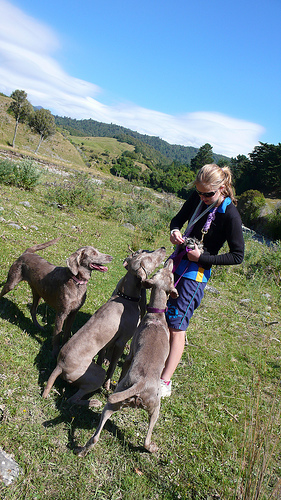

In [ ]:
from PIL import Image

Image.open('/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg')

Let's make a DataFrame with path to images and captions as columns.

In [ ]:
import io
import numpy as np
import pandas as pd

# Setting seed
np.random.seed(42)

# Load the captions string into a pandas DataFrame
buff = io.StringIO(captions)
df = pd.read_csv(buff)
# Construct the full path for each image file
df.image = df.image.apply (lambda im_path: os.path.join(path, 'Images', im_path))

df.head(10)

image  \
0  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4  /kaggle/input/flickr8k/Images/1000268201_693b0...   
5  /kaggle/input/flickr8k/Images/1001773457_577c3...   
6  /kaggle/input/flickr8k/Images/1001773457_577c3...   
7  /kaggle/input/flickr8k/Images/1001773457_577c3...   
8  /kaggle/input/flickr8k/Images/1001773457_577c3...   
9  /kaggle/input/flickr8k/Images/1001773457_577c3...   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

It looks like there are a lot of duplicates in the dataset.

In [ ]:
df = df.sort_values('image').reset_index(drop=True)

df.head(12).image.values

array(['/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
       '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg'],
      dtype=object)

The dataset consists of 40455 images with captions, but only 8091 images are unique. It means that there are 5 different captions for each image.

We'll do the following:
- Set a random rank(1-5) for the image within its image group
- Marker each image that has the rank less than 5 as the one which will be used in the training process
- The rest of the images will be used for the test and validation sets

The distribution will look like this:
- 32364 for the train set
- 4046 for the test set
- 4045 for the validation set

In [ ]:
len(df), df.image.nunique(), 8091 // 2 + 1, 8091 // 2

(40455, 8091, 4046, 4045)

In [ ]:
df['random_rank'] = df.groupby('image').image.transform(
    lambda x: np.random.permutation(len(x))
)
df['is_train'] = df['random_rank'] < 4

df.head(12)

image  \
0   /kaggle/input/flickr8k/Images/1000268201_693b0...   
1   /kaggle/input/flickr8k/Images/1000268201_693b0...   
2   /kaggle/input/flickr8k/Images/1000268201_693b0...   
3   /kaggle/input/flickr8k/Images/1000268201_693b0...   
4   /kaggle/input/flickr8k/Images/1000268201_693b0...   
5   /kaggle/input/flickr8k/Images/1001773457_577c3...   
6   /kaggle/input/flickr8k/Images/1001773457_577c3...   
7   /kaggle/input/flickr8k/Images/1001773457_577c3...   
8   /kaggle/input/flickr8k/Images/1001773457_577c3...   
9   /kaggle/input/flickr8k/Images/1001773457_577c3...   
10  /kaggle/input/flickr8k/Images/1002674143_1b742...   
11  /kaggle/input/flickr8k/Images/1002674143_1b742...   

                                              caption  random_rank  is_train  
0   A child in a pink dress is climbing up a set o...            1      True  
1               A girl going into a wooden building .            4     False  
2    A little girl climbing into a wooden playhouse .            2      True  
3   A little girl climbing the stairs to her playh...            0      True  
4   A little girl in a pink dress going into a woo...            3      True  
5     Two dogs on pavement moving toward each other .            3      True  
6   A black dog and a white dog with brown spots a...            1      True  
7   Two dogs of different breeds looking at each o...            2      True  
8          A black dog and a spotted dog are fighting            0      True  
9   A black dog and a tri-colored dog playing with...            4     False  
10  A little girl covered in paint sits in front o...            1      True  
11  A little girl is sitting in front of a large p...            0      True

In [ ]:
# Check the number of samples in the train set
df.is_train.sum()

np.int64(32364)

In [ ]:
train_df = df[df.is_train]

res_df = df[~df.is_train]
res_df = res_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 4046
test_df = res_df.iloc[:test_size].reset_index(drop=True)
valid_df = res_df.iloc[test_size:].reset_index(drop=True)

# Check the distribution
len(train_df), len(test_df), len(valid_df)

(32364, 4046, 4045)

In [ ]:
import torch
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set()

We'll use OpenAI GPT2 as the decoder.

**GPT-2 Overview**

`GPT-2`, which stands for `Generative Pre-trained Transformer 2`, is a powerful language model designed to generate coherent and human-like text. Unlike `BERT`, it processes text in a strictly left-to-right, autoregressive direction, allowing it to predict the next word in a sequence based only on the words that have come before it. `GPT-2` is pre-trained on a massive dataset of text from the internet with a single, elegant objective: to predict the next word given a preceding context. This focused, generative pre-training enables `GPT-2` to excel at a wide range of text generation tasks, from writing articles and completing sentences to creating conversational AI.

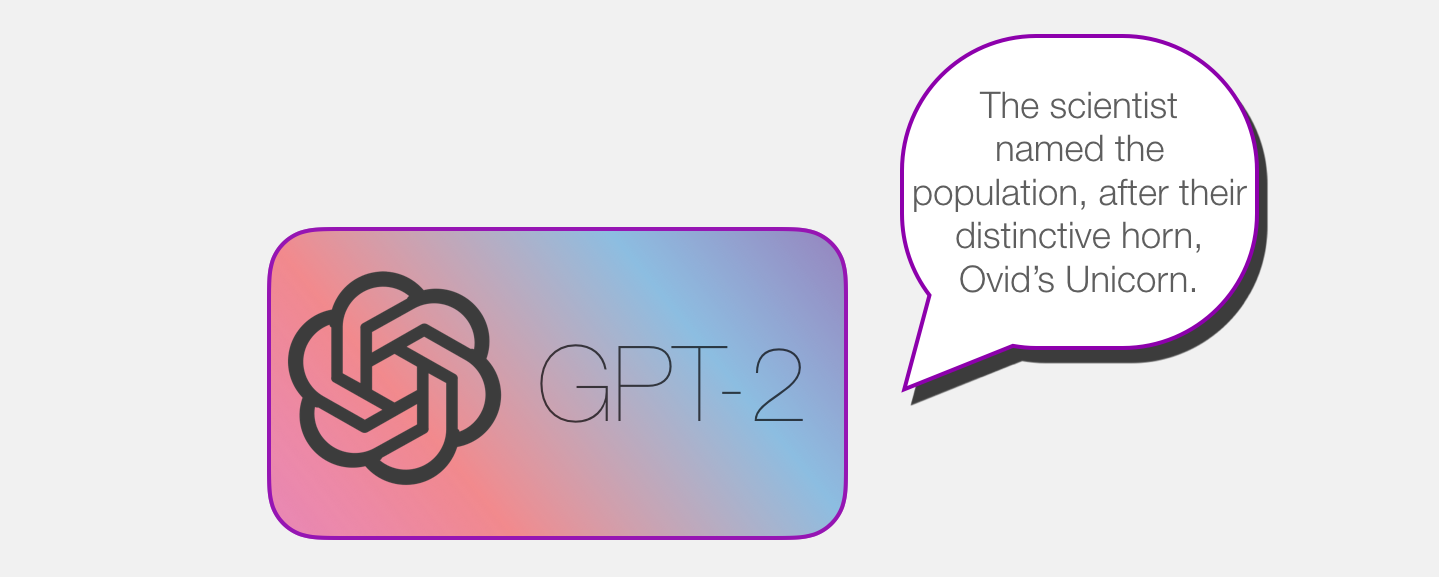

In [ ]:
from transformers import AutoTokenizer

llm_id = 'openai-community/gpt2'
tokenizer = AutoTokenizer.from_pretrained(llm_id)

tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Let's analyze the captions to determine the maximum sequence length.

In [ ]:
def get_num_tokens(text: str) -> int:
    return len(tokenizer(text).input_ids)

df['tokens_per_description'] = df.caption.map(get_num_tokens)

df.head()

index                                              image  \
0      0  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1      1  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2      2  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3      3  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4      4  /kaggle/input/flickr8k/Images/1000268201_693b0...   

                                             caption  random_rank  is_train  \
0  A child in a pink dress is climbing up a set o...            1      True   
1              A girl going into a wooden building .            4     False   
2   A little girl climbing into a wooden playhouse .            2      True   
3  A little girl climbing the stairs to her playh...            0      True   
4  A little girl in a pink dress going into a woo...            3      True   

   tokens_per_description  
0                      18  
1                       8  
2                      10  
3                      11  
4                      13

In [ ]:
df.tokens_per_description.max()

41

The longest caption is 41 tokens long. We'll save this value for later.

In [ ]:
from torch.utils.data import Dataset


class ImageCaptionDataset(Dataset):
    """Dataset that returns prcessed images with LVM processor and LLM tokenizer"""

    def __init__(self, df, processor, tokenizer, max_length=41):
        self.images = df.image.values.tolist()
        self.captions = df.caption.values.tolist()
        self.processor = processor
        self.tokenizer = tokenizer
        # Tokens from the text + <|endoftext|> token
        self.max_length = max_length + 1

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Reading the image and getting pixel values
        image = Image.open(self.images[idx]).convert('RGB')
        im_inputs = self.processor(images=image, return_tensors='pt')
        pixel_values = im_inputs['pixel_values'].squeeze(0)

        # Tokenizing the caption and getting input ids
        caption = self.captions[idx]
        text_inputs = self.tokenizer(
            caption,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_length
        )

        input_ids = torch.tensor(text_inputs.input_ids)
        input_ids[input_ids == tokenizer.pad_token_id] = -100

        return pixel_values, input_ids

There are two important points to note about the code above:
- We set `max_length` 41 based on our analysis
- We replace all `input_ids` that are equal to `GPT-2` `[PAD]` token id with `-100` because torch uses this constant as the marker to ignore these specific tokens during loss calculation

Let's load our `LVM(Google ViT)` and then create the datasets.

In [ ]:
from transformers import AutoImageProcessor

lvm_id = 'google/vit-base-patch16-224'
processor = AutoImageProcessor.from_pretrained(lvm_id, use_fast=True)

train_ds = ImageCaptionDataset(train_df, processor, tokenizer)
test_ds = ImageCaptionDataset(test_df, processor, tokenizer)
valid_ds = ImageCaptionDataset(valid_df, processor, tokenizer)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

**Vision Transformer (ViT) Overview**

The `Vision Transformer (ViT)` is a seminal model that first demonstrated that a pure Transformer architecture, prevalent in natural language processing, could be directly applied to computer vision tasks with minimal modifications. It processes images by first splitting them into a sequence of fixed-size, non-overlapping patches, which are then flattened and linearly embedded into vectors. To retain positional information, learnable position embeddings are added to these patch embeddings, and the entire sequence is prepended with a special `[CLS]` token, whose corresponding output is used for classification. The model then feeds this sequence of vectors into a standard Transformer encoder, which applies global self-attention uniformly across all patches, allowing every patch to interact with every other patch from the very first layer. This straightforward approach of treating an image as a sequence of patches enables `ViT` to achieve remarkable performance, particularly when pre-trained on large datasets, establishing a new paradigm for computer vision models.

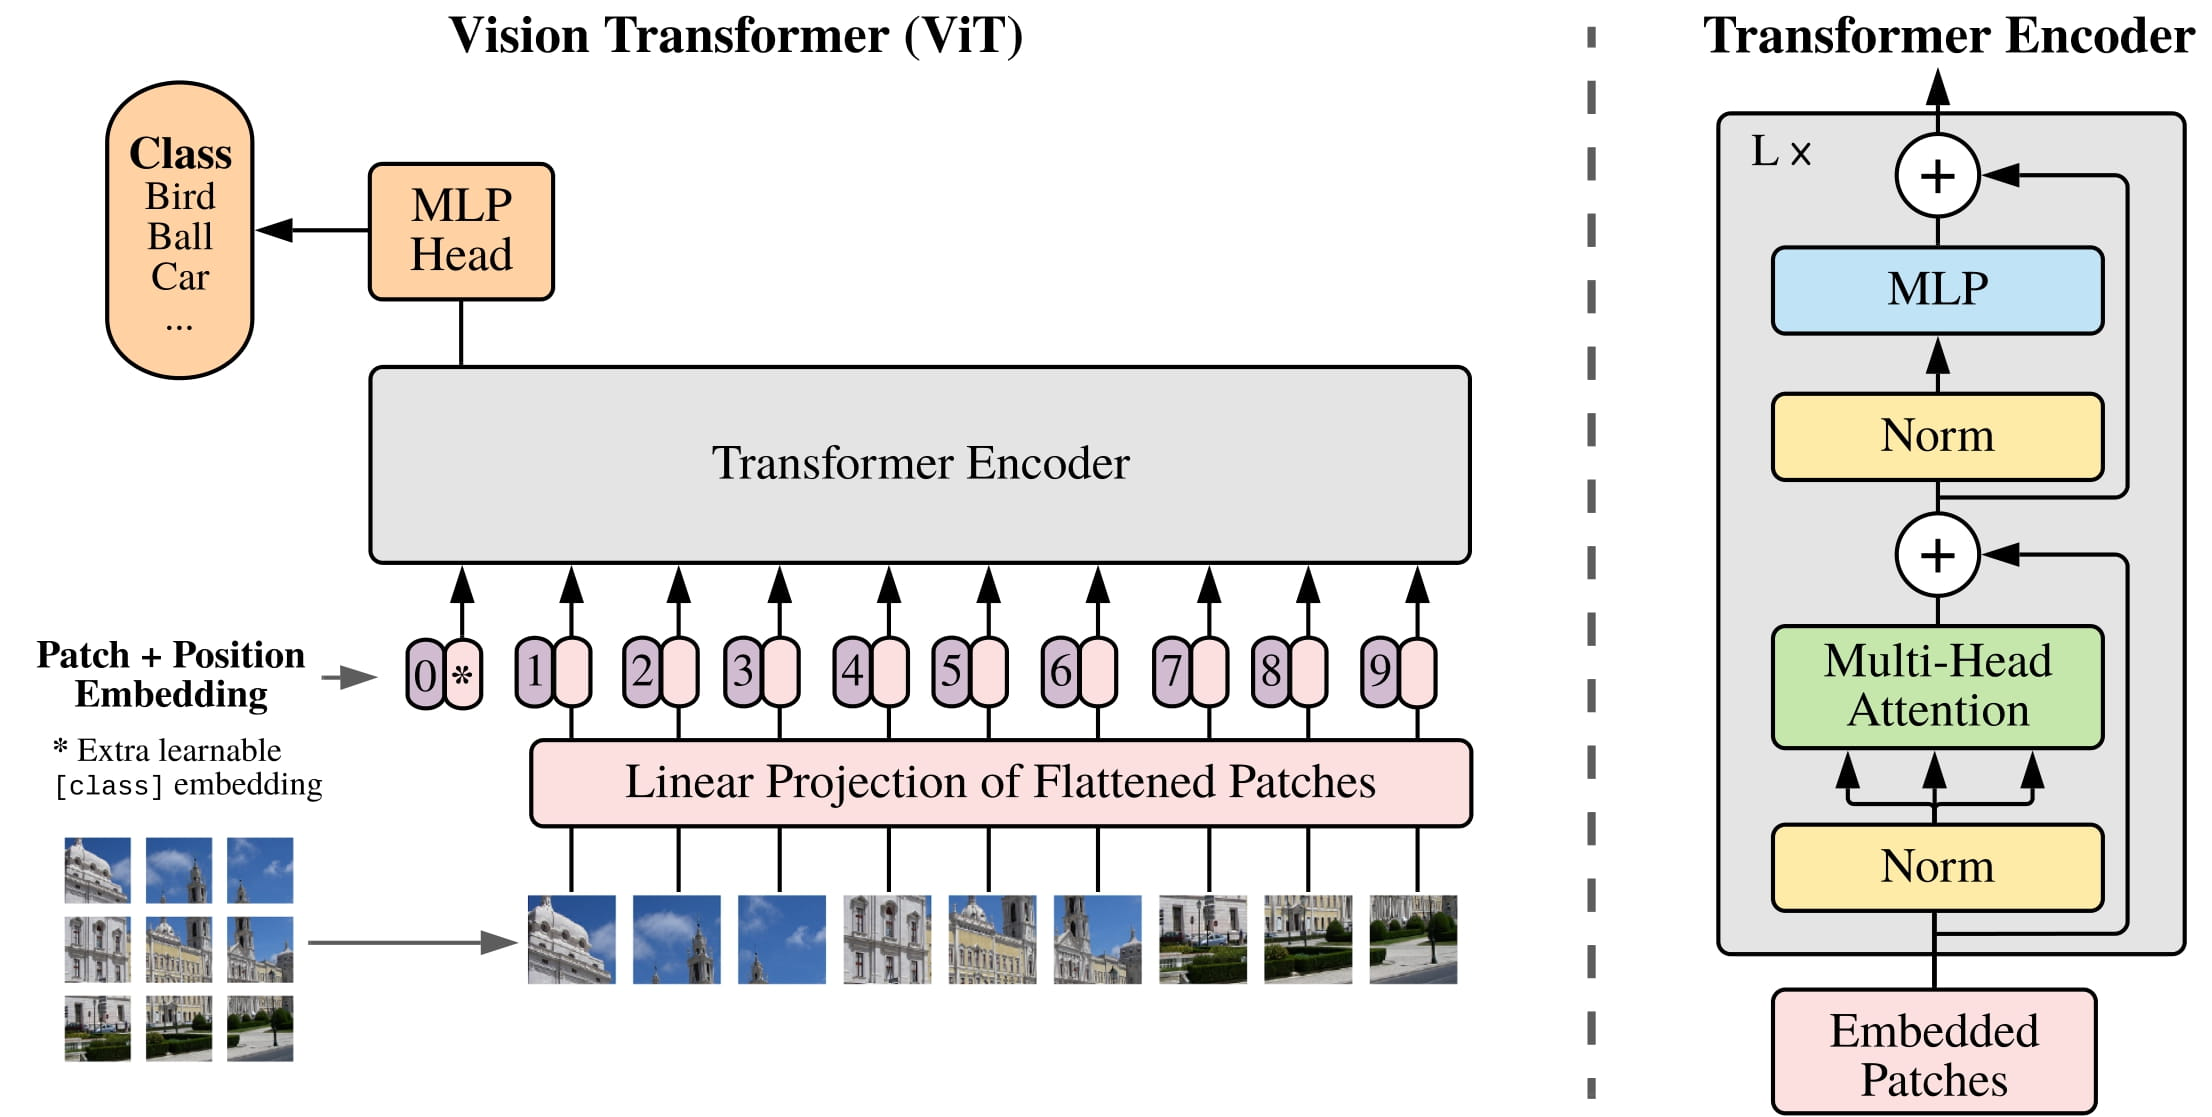

In [ ]:
# Verify the output of the dataset
train_ds[0]

(tensor([[[-0.3569, -0.1294, -0.0902,  ..., -0.9686, -0.9529, -0.9529],
          [-0.3804, -0.1137, -0.0667,  ..., -0.9373, -0.9451, -0.9059],
          [-0.3961, -0.0824, -0.0588,  ..., -0.9373, -0.9451, -0.9216],
          ...,
          [ 0.4588,  0.1765,  0.3412,  ...,  0.6627,  0.2941,  0.2941],
          [ 0.3882,  0.3961,  0.7255,  ...,  0.6392,  0.3176,  0.3176],
          [ 0.6235,  0.6392,  0.4667,  ...,  0.6078,  0.3098,  0.3255]],
 
         [[-0.3098,  0.0039,  0.0510,  ..., -0.9765, -0.9529, -0.9373],
          [-0.3412,  0.0118,  0.0824,  ..., -0.9294, -0.9216, -0.8353],
          [-0.3804,  0.0353,  0.1059,  ..., -0.9216, -0.8980, -0.8275],
          ...,
          [-0.1529, -0.3725, -0.0431,  ...,  0.7255,  0.4431,  0.4431],
          [-0.2471,  0.0118,  0.3255,  ...,  0.7098,  0.4431,  0.4431],
          [-0.0118,  0.1608, -0.0431,  ...,  0.6784,  0.4431,  0.4431]],
 
         [[-0.2392, -0.0196, -0.0039,  ..., -0.9765, -0.9686, -0.9608],
          [-0.2784,  0.0118,

The datasets are ready, now we need to define the dataloaders.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
cpu_count = os.cpu_count() # 12
params = dict(
    shuffle=True,
    batch_size=batch_size,
    num_workers=cpu_count,
    pin_memory=True
)

train_dl = DataLoader(train_ds, **params)
test_dl = DataLoader(test_ds, **params)
valid_dl = DataLoader(valid_ds, **params)

In the code above, we set up parallel processing for data loading by setting `num_workers` to the number of available CPU cores, which helps speed things up. We also optimized data transfer from the CPU to the GPU by setting `pin_memory` to `True`.

Now we need to download the full model.

In [ ]:
from transformers import VisionEncoderDecoderModel


model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(lvm_id, llm_id)

# ids
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 41
model.config.no_repeat_ngram_size = 3
model.config.num_beams = 1

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'tran

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inte

We have the data loaders and the model. Now, we need to define the remaining training components, such as the optimizer, number of training epochs, learning rate scheduler, compute device, and the `ROUGE score` for our evaluation metric.

In [ ]:
import evaluate
from torch.optim import AdamW
from transformers import get_scheduler

epochs = 30
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = epochs * len(train_dl)
num_warmup_steps = num_training_steps // 5

scheduler = get_scheduler(name='linear', optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

metric = evaluate.load('rouge')

Everything is set up, now we may implement some extra functions for the training process.

In [ ]:
from tqdm import tqdm

def evaluate_with_rouge(model, dl, tokenizer, metric, device):
    """
    Method to evaluate model's performance on a given dataset using the ROUGE metric

    :param model: The model to evaluate
    :param dl: The DataLoader for the evaluation data
    :param tokenizer: The tokenizer used to decode predictions and labels
    :param metric: The ROUGE metric object from the `evaluate` library
    :param device: The device for evaluation
    :return: A dictionary with the computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.eval()

    progress_bar = tqdm(dl, desc='Calculating Rouge', leave=False)

    for pixel_values, input_ids in progress_bar:
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Disable gradient calculation for faster and less memory-intensive inference
        with torch.no_grad():
            outputs = model(
                pixel_values=pixel_values,
                labels=labels
            )

        # Get the most likely token ID for each position in the sequence
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Decode the predicted token IDs into text
        predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        # Minor cleanup on the predictions to improve scoring alignment
        predictions = [pred_caption.replace('.', '') for pred_caption in predictions]
        # Labels use -100 to mask padding, replace with [PAD] token id for correct decoding
        references = [
            tokenizer.decode(
                [tokenizer.pad_token_id if token == -100 else token for token in reference],
                skip_special_tokens=True
            )
            for reference in labels.tolist()
        ]
        # Add the current batch of predictions and references to the metric accumulator
        metric.add_batch(predictions=predictions, references=references)

    return metric.compute()

In [ ]:
def train_one_epoch(model, dl, optimizer, scheduler, device, tokenizer, metric):
    """
    Function that trains the model for a single epoch

    :param model: The model to be trained
    :param dl: DataLoader for the training data
    :param optimizer: The optimizer for updating model weights
    :param scheduler: The learning rate scheduler
    :param device: The device for training
    :param tokenizer: GPT-2 tokenizer for decoding
    :param metric: The metric object to evaluate rouge1, rouge2, rougeL and rougeLsum
    :return: A dictionary with loss and computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.train()

    total_loss = 0
    progress_bar = tqdm(dl, desc='Training', leave=False)

    for pixel_values, input_ids in progress_bar:
        # Move data to the specified computation device.
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Perform a forward pass through the model.
        # The model returns outputs including the loss.
        outputs = model(
            pixel_values=pixel_values,
            labels=labels
        )
        loss = outputs.loss

        # Backpropagation: compute gradients, update weights, and clear gradients.
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update the progress bar with the loss for the current batch.
        progress_bar.set_postfix(loss=loss.item())

        total_loss += loss.item()

    # Calculate the average loss over all batches.
    avg_loss = total_loss / len(dl)

    # Evaluate the model on the training data at the end of the epoch.
    rouge_scores = evaluate_with_rouge(model, dl, tokenizer, metric, device)

    return {'loss': avg_loss, **rouge_scores}

In [ ]:
def evaluate(model, dl, device, tokenizer, metric):
    """
    Method to evaluate the model on a given dataset

    :param model: The model to evaluate
    :param dl: DataLoader for the evaluation data
    :param device: The device for evaluation
    :param tokenizer: GPT-2 tokenizer for decoding predictions
    :param metric: The metric object to evaluate rouge1, rouge2, rougeL and rougeLsum
    :return: A dictionary with loss and computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.eval()

    total_loss = 0
    progress_bar = tqdm(dl, desc='Evaluating', leave=False)

    for pixel_values, input_ids in progress_bar:
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Disable gradient calculation for inference.
        with torch.no_grad():
            outputs = model(
                pixel_values=pixel_values,
                labels=labels
            )

        # Accumulate the loss for the batch.
        loss = outputs.loss
        total_loss += loss.item()

        # Update the progress bar with the current batch's loss.
        progress_bar.set_postfix(loss=loss.item())

    # Calculate the average loss across all batches.
    avg_loss = total_loss / len(dl)

    # Use the separate function to get ROUGE scores for the whole dataset.
    rouge_scores = evaluate_with_rouge(model, dl, tokenizer, metric, device)

    # Return a dictionary with the average loss and the ROUGE scores.
    return {'loss': avg_loss, **rouge_scores}

In [ ]:
class History:
    """Plcaholder to store training metrics and loss in a structured format"""

    def __init__(self):
        self._history = {'loss': [], 'rouge1': [], 'rouge2': [], 'rougeL': [], 'rougeLsum': []}

    def update(self, metrics):
        self._history ['loss'].append(metrics.get('loss', 0.0))
        self._history ['rouge1'].append(metrics.get('rouge1', 0.0))
        self._history ['rouge2'].append(metrics.get('rouge2', 0.0))
        self._history ['rougeL'].append(metrics.get('rougeL', 0.0))
        self._history ['rougeLsum'].append(metrics.get('rougeLsum', 0.0))

    def to_df(self):
        return pd.DataFrame(self._history)

    @property
    def hist_metrics(self):
        return self._history

We have all necessary stuff to start the training. So, let's do it!

In [ ]:
train_history = History()
test_history = History()

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')

    train_metrics = train_one_epoch(model, train_dl, optimizer, scheduler, device, tokenizer, metric)
    test_metrics = evaluate(model, test_dl, device, tokenizer, metric)

    print(f"Train | Loss: {train_metrics['loss']:.3f} | Rouge1: {train_metrics['rouge1']:.5f} | Rouge2: {train_metrics['rouge2']:.5f} | RougeL: {train_metrics['rougeL']:.5f} | RougeLsum: {train_metrics['rougeLsum']:.5f}")
    print(f" Test | Loss: {test_metrics['loss']:.3f} | Rouge1: {test_metrics['rouge1']:.5f} | Rouge2: {test_metrics['rouge2']:.5f} | RougeL: {test_metrics['rougeL']:.5f} | RougeLsum: {test_metrics['rougeLsum']:.5f}\n")

    train_history.update(train_metrics)
    test_history.update(test_metrics)

    model.save_pretrained(f'model_epoch_{epoch}')

Epoch 1/30


Training:   0%|          | 0/1012 [00:00<?, ?it/s]`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Train | Loss: 5.919 | Rouge1: 0.14783 | Rouge2: 0.01619 | RougeL: 0.11663 | RougeLsum: 0.11660
 Test | Loss: 4.496 | Rouge1: 0.14761 | Rouge2: 0.01585 | RougeL: 0.11646 | RougeLsum: 0.11640

Epoch 2/30


Train | Loss: 4.264 | Rouge1: 0.17146 | Rouge2: 0.03131 | RougeL: 0.13399 | RougeLsum: 0.13398
 Test | Loss: 3.938 | Rouge1: 0.17077 | Rouge2: 0.03079 | RougeL: 0.13320 | RougeLsum: 0.13321

Epoch 3/30


Train | Loss: 3.847 | Rouge1: 0.18612 | Rouge2: 0.04323 | RougeL: 0.14742 | RougeLsum: 0.14742
 Test | Loss: 3.638 | Rouge1: 0.18289 | Rouge2: 0.03991 | RougeL: 0.14448 | RougeLsum: 0.14453

Epoch 4/30


Train | Loss: 3.554 | Rouge1: 0.19784 | Rouge2: 0.05224 | RougeL: 0.15878 | RougeLsum: 0.15877
 Test | Loss: 3.472 | Rouge1: 0.18835 | Rouge2: 0.04444 | RougeL: 0.15022 | RougeLsum: 0.15018

Epoch 5/30


Train | Loss: 3.304 | Rouge1: 0.21190 | Rouge2: 0.06318 | RougeL: 0.17196 | RougeLsum: 0.17196
 Test | Loss: 3.359 | Rouge1: 0.19409 | Rouge2: 0.05057 | RougeL: 0.15601 | RougeLsum: 0.15593

Epoch 6/30


Train | Loss: 3.075 | Rouge1: 0.22168 | Rouge2: 0.07151 | RougeL: 0.18226 | RougeLsum: 0.18226
 Test | Loss: 3.316 | Rouge1: 0.19761 | Rouge2: 0.05234 | RougeL: 0.15948 | RougeLsum: 0.15944

Epoch 7/30


Train | Loss: 2.849 | Rouge1: 0.24744 | Rouge2: 0.08559 | RougeL: 0.20568 | RougeLsum: 0.20571
 Test | Loss: 3.282 | Rouge1: 0.20844 | Rouge2: 0.05606 | RougeL: 0.16926 | RougeLsum: 0.16934

Epoch 8/30


Train | Loss: 2.612 | Rouge1: 0.25270 | Rouge2: 0.09557 | RougeL: 0.21285 | RougeLsum: 0.21284
 Test | Loss: 3.285 | Rouge1: 0.20376 | Rouge2: 0.05502 | RougeL: 0.16604 | RougeLsum: 0.16613

Epoch 9/30


Train | Loss: 2.393 | Rouge1: 0.27302 | Rouge2: 0.11427 | RougeL: 0.23373 | RougeLsum: 0.23380
 Test | Loss: 3.365 | Rouge1: 0.20528 | Rouge2: 0.05401 | RougeL: 0.16769 | RougeLsum: 0.16769

Epoch 10/30


Train | Loss: 2.191 | Rouge1: 0.29365 | Rouge2: 0.13485 | RougeL: 0.25545 | RougeLsum: 0.25543
 Test | Loss: 3.432 | Rouge1: 0.20931 | Rouge2: 0.05629 | RougeL: 0.17264 | RougeLsum: 0.17262

Epoch 11/30


Train | Loss: 1.998 | Rouge1: 0.30779 | Rouge2: 0.15340 | RougeL: 0.27275 | RougeLsum: 0.27272
 Test | Loss: 3.518 | Rouge1: 0.20855 | Rouge2: 0.05533 | RougeL: 0.17177 | RougeLsum: 0.17169

Epoch 12/30


Train | Loss: 1.821 | Rouge1: 0.31640 | Rouge2: 0.16963 | RougeL: 0.28121 | RougeLsum: 0.28117
 Test | Loss: 3.677 | Rouge1: 0.20468 | Rouge2: 0.05341 | RougeL: 0.16728 | RougeLsum: 0.16729

Epoch 13/30


Train | Loss: 1.658 | Rouge1: 0.32731 | Rouge2: 0.18999 | RougeL: 0.29639 | RougeLsum: 0.29646
 Test | Loss: 3.831 | Rouge1: 0.20083 | Rouge2: 0.05328 | RougeL: 0.16541 | RougeLsum: 0.16553

Epoch 14/30


Train | Loss: 1.510 | Rouge1: 0.33494 | Rouge2: 0.20832 | RougeL: 0.30729 | RougeLsum: 0.30724
 Test | Loss: 3.972 | Rouge1: 0.19438 | Rouge2: 0.05037 | RougeL: 0.16084 | RougeLsum: 0.16083

Epoch 15/30


Train | Loss: 1.382 | Rouge1: 0.35406 | Rouge2: 0.22944 | RougeL: 0.32346 | RougeLsum: 0.32345
 Test | Loss: 4.164 | Rouge1: 0.19992 | Rouge2: 0.05076 | RougeL: 0.16338 | RougeLsum: 0.16324

Epoch 16/30


Train | Loss: 1.266 | Rouge1: 0.35703 | Rouge2: 0.24541 | RougeL: 0.33120 | RougeLsum: 0.33119
 Test | Loss: 4.340 | Rouge1: 0.19421 | Rouge2: 0.04995 | RougeL: 0.15922 | RougeLsum: 0.15930

Epoch 17/30


Train | Loss: 1.158 | Rouge1: 0.36505 | Rouge2: 0.25932 | RougeL: 0.33953 | RougeLsum: 0.33954
 Test | Loss: 4.476 | Rouge1: 0.19423 | Rouge2: 0.04921 | RougeL: 0.15920 | RougeLsum: 0.15934

Epoch 18/30


Train | Loss: 1.064 | Rouge1: 0.38463 | Rouge2: 0.28368 | RougeL: 0.36029 | RougeLsum: 0.36030
 Test | Loss: 4.623 | Rouge1: 0.20050 | Rouge2: 0.05072 | RougeL: 0.16439 | RougeLsum: 0.16434

Epoch 19/30


Train | Loss: 0.982 | Rouge1: 0.39011 | Rouge2: 0.29575 | RougeL: 0.36811 | RougeLsum: 0.36807
 Test | Loss: 4.765 | Rouge1: 0.19713 | Rouge2: 0.05043 | RougeL: 0.16265 | RougeLsum: 0.16264

Epoch 20/30


Train | Loss: 0.910 | Rouge1: 0.39296 | Rouge2: 0.30341 | RougeL: 0.36971 | RougeLsum: 0.36976
 Test | Loss: 4.855 | Rouge1: 0.19801 | Rouge2: 0.05000 | RougeL: 0.16167 | RougeLsum: 0.16174

Epoch 21/30


Train | Loss: 0.847 | Rouge1: 0.39602 | Rouge2: 0.31049 | RougeL: 0.37306 | RougeLsum: 0.37299
 Test | Loss: 5.007 | Rouge1: 0.19632 | Rouge2: 0.04913 | RougeL: 0.16001 | RougeLsum: 0.15982

Epoch 22/30


Train | Loss: 0.791 | Rouge1: 0.39506 | Rouge2: 0.31455 | RougeL: 0.37339 | RougeLsum: 0.37341
 Test | Loss: 5.087 | Rouge1: 0.19445 | Rouge2: 0.04859 | RougeL: 0.15888 | RougeLsum: 0.15896

Epoch 23/30


Train | Loss: 0.742 | Rouge1: 0.39515 | Rouge2: 0.31868 | RougeL: 0.37512 | RougeLsum: 0.37517
 Test | Loss: 5.191 | Rouge1: 0.19068 | Rouge2: 0.04851 | RougeL: 0.15696 | RougeLsum: 0.15701

Epoch 24/30


Train | Loss: 0.699 | Rouge1: 0.39821 | Rouge2: 0.32384 | RougeL: 0.37865 | RougeLsum: 0.37858
 Test | Loss: 5.264 | Rouge1: 0.19100 | Rouge2: 0.04778 | RougeL: 0.15665 | RougeLsum: 0.15664

Epoch 25/30


Train | Loss: 0.658 | Rouge1: 0.40066 | Rouge2: 0.32715 | RougeL: 0.38019 | RougeLsum: 0.38017
 Test | Loss: 5.356 | Rouge1: 0.19333 | Rouge2: 0.04880 | RougeL: 0.15781 | RougeLsum: 0.15770

Epoch 26/30


Train | Loss: 0.623 | Rouge1: 0.39972 | Rouge2: 0.32765 | RougeL: 0.37911 | RougeLsum: 0.37912
 Test | Loss: 5.408 | Rouge1: 0.19101 | Rouge2: 0.04755 | RougeL: 0.15566 | RougeLsum: 0.15564

Epoch 27/30


Train | Loss: 0.595 | Rouge1: 0.40250 | Rouge2: 0.33134 | RougeL: 0.38181 | RougeLsum: 0.38182
 Test | Loss: 5.483 | Rouge1: 0.19261 | Rouge2: 0.04812 | RougeL: 0.15721 | RougeLsum: 0.15722

Epoch 28/30


Train | Loss: 0.566 | Rouge1: 0.40633 | Rouge2: 0.33588 | RougeL: 0.38604 | RougeLsum: 0.38600
 Test | Loss: 5.534 | Rouge1: 0.19170 | Rouge2: 0.04802 | RougeL: 0.15699 | RougeLsum: 0.15692

Epoch 29/30


Train | Loss: 0.543 | Rouge1: 0.40565 | Rouge2: 0.33608 | RougeL: 0.38547 | RougeLsum: 0.38549
 Test | Loss: 5.598 | Rouge1: 0.19136 | Rouge2: 0.04796 | RougeL: 0.15644 | RougeLsum: 0.15638

Epoch 30/30


Train | Loss: 0.525 | Rouge1: 0.40507 | Rouge2: 0.33556 | RougeL: 0.38479 | RougeLsum: 0.38484
 Test | Loss: 5.627 | Rouge1: 0.19086 | Rouge2: 0.04811 | RougeL: 0.15618 | RougeLsum: 0.15610



In [ ]:
train_history.to_df()

loss    rouge1    rouge2    rougeL  rougeLsum
0   5.918996  0.147833  0.016189  0.116628   0.116601
1   4.264093  0.171463  0.031308  0.133986   0.133980
2   3.847135  0.186124  0.043232  0.147419   0.147420
3   3.554468  0.197844  0.052239  0.158779   0.158766
4   3.304162  0.211896  0.063180  0.171961   0.171958
5   3.075271  0.221681  0.071509  0.182258   0.182258
6   2.849023  0.247437  0.085593  0.205681   0.205710
7   2.611812  0.252697  0.095566  0.212854   0.212843
8   2.392953  0.273023  0.114271  0.233735   0.233804
9   2.190687  0.293655  0.134849  0.255449   0.255427
10  1.997912  0.307791  0.153402  0.272751   0.272720
11  1.821216  0.316402  0.169629  0.281208   0.281171
12  1.657908  0.327309  0.189986  0.296390   0.296459
13  1.510140  0.334944  0.208316  0.307287   0.307243
14  1.382040  0.354057  0.229436  0.323457   0.323453
15  1.265904  0.357034  0.245410  0.331199   0.331188
16  1.158193  0.365047  0.259321  0.339532   0.339543
17  1.063818  0.384634  0.283680  0.360294   0.360296
18  0.981652  0.390108  0.295746  0.368108   0.368069
19  0.909847  0.392958  0.303408  0.369708   0.369763
20  0.847448  0.396025  0.310495  0.373061   0.372995
21  0.790821  0.395061  0.314547  0.373387   0.373409
22  0.741743  0.395152  0.318678  0.375120   0.375168
23  0.699308  0.398209  0.323842  0.378648   0.378579
24  0.657850  0.400659  0.327147  0.380186   0.380165
25  0.622987  0.399721  0.327654  0.379113   0.379121
26  0.594947  0.402504  0.331341  0.381808   0.381822
27  0.565959  0.406334  0.335885  0.386037   0.385998
28  0.543306  0.405654  0.336081  0.385468   0.385489
29  0.524648  0.405075  0.335563  0.384792   0.384840

In [ ]:
test_history.to_df()

loss    rouge1    rouge2    rougeL  rougeLsum
0   4.495875  0.147608  0.015850  0.116457   0.116398
1   3.938165  0.170767  0.030787  0.133197   0.133209
2   3.637948  0.182886  0.039913  0.144478   0.144535
3   3.472217  0.188352  0.044442  0.150221   0.150176
4   3.358530  0.194091  0.050566  0.156006   0.155928
5   3.315552  0.197609  0.052340  0.159485   0.159436
6   3.281541  0.208444  0.056062  0.169261   0.169343
7   3.284887  0.203761  0.055019  0.166037   0.166134
8   3.364585  0.205281  0.054008  0.167693   0.167694
9   3.432078  0.209311  0.056294  0.172641   0.172616
10  3.517939  0.208549  0.055332  0.171773   0.171692
11  3.676798  0.204675  0.053413  0.167284   0.167288
12  3.830561  0.200834  0.053282  0.165412   0.165531
13  3.972162  0.194385  0.050373  0.160839   0.160833
14  4.164318  0.199924  0.050761  0.163383   0.163241
15  4.339892  0.194206  0.049948  0.159222   0.159295
16  4.476430  0.194227  0.049206  0.159204   0.159337
17  4.623119  0.200505  0.050717  0.164388   0.164342
18  4.765115  0.197132  0.050426  0.162646   0.162643
19  4.855268  0.198009  0.049999  0.161673   0.161735
20  5.007042  0.196317  0.049128  0.160007   0.159821
21  5.086942  0.194446  0.048591  0.158876   0.158957
22  5.191496  0.190684  0.048513  0.156962   0.157009
23  5.264490  0.191002  0.047778  0.156653   0.156638
24  5.355679  0.193325  0.048801  0.157810   0.157698
25  5.408084  0.191013  0.047548  0.155661   0.155643
26  5.482677  0.192610  0.048121  0.157208   0.157222
27  5.533723  0.191705  0.048020  0.156991   0.156924
28  5.597802  0.191364  0.047958  0.156443   0.156385
29  5.627496  0.190859  0.048111  0.156176   0.156104

In [ ]:
pd.DataFrame(evaluate(model, train_dl, device, tokenizer, metric), index=['Train Metrics']).T

Train Metrics
loss            0.291606
rouge1          0.405039
rouge2          0.335638
rougeL          0.384845
rougeLsum       0.384849

In [ ]:
pd.DataFrame(evaluate(model, test_dl, device, tokenizer, metric), index=['Test Metrics']).T

Test Metrics
loss           5.624871
rouge1         0.190828
rouge2         0.048132
rougeL         0.156082
rougeLsum      0.156174

In [ ]:
pd.DataFrame(evaluate(model, valid_dl, device, tokenizer, metric), index=['Validation Metrics']).T

Validation Metrics
loss                 5.715792
rouge1               0.190173
rouge2               0.048213
rougeL               0.156856
rougeLsum            0.156812

As we can see, the model is extremely overfitted to the training dataset with `ViT + GPT-2` as well. This is likely because the training, test and validation sets use the same images, but with different captions. Now, let's see how the model generates captions.

In [ ]:
model.eval()

In [ ]:
pixel_values = valid_ds[3][0].unsqueeze(0)

# Trying to generate a caption
predictions = tokenizer.decode(model.generate(pixel_values=pixel_values.to(device))[0], skip_special_tokens=True)
caption = predictions.replace('.', '').strip()

caption

"people blind by inf in- 'var community '  blindolds aned  wall  ' wall in of  words white ed  area white Sal o 'ware  ' walls two people"

In [ ]:
# Select random images from the validation set
ids = np.random.choice(np.arange(len(valid_dl)), 15, replace=False).astype(int)

ids

array([125,  26, 119,  61, 102, 101,  23,  42, 111,  97, 122,  48,  54,
        16,  95])

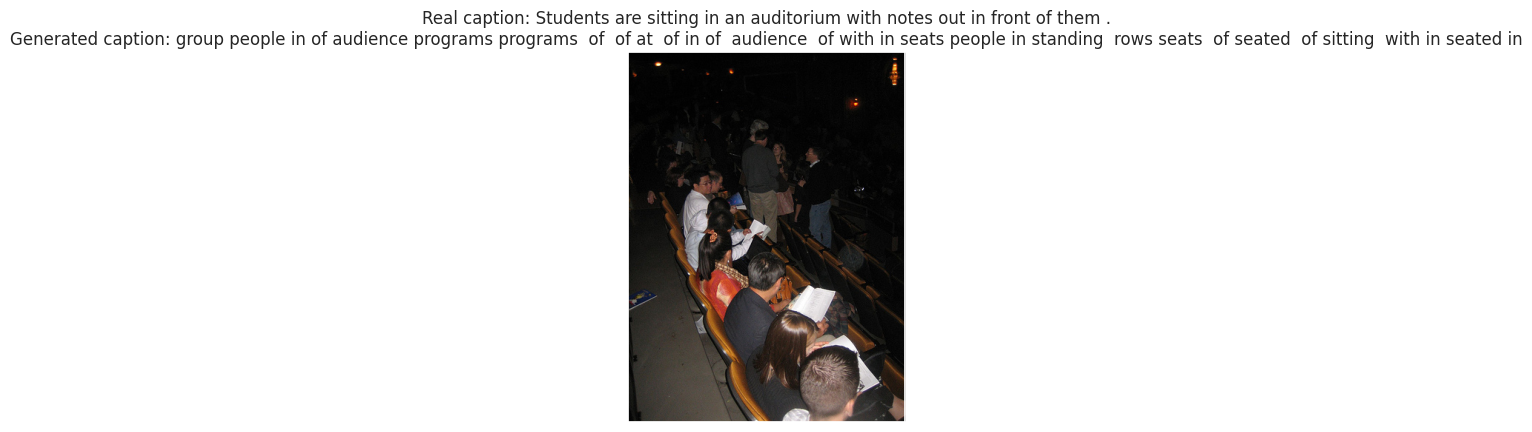

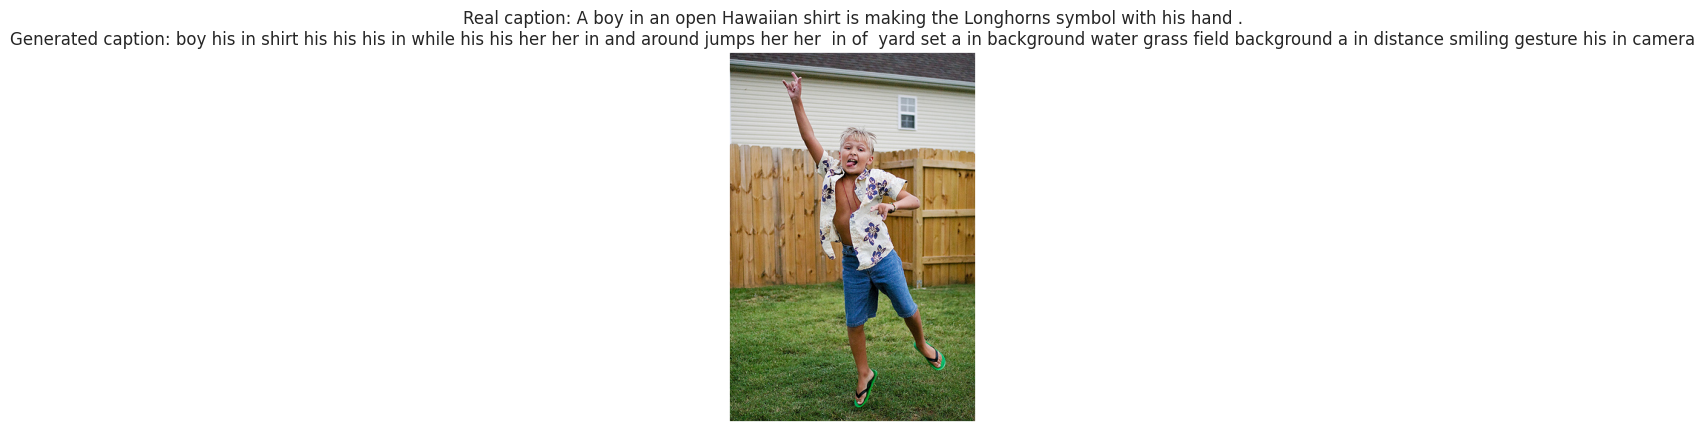

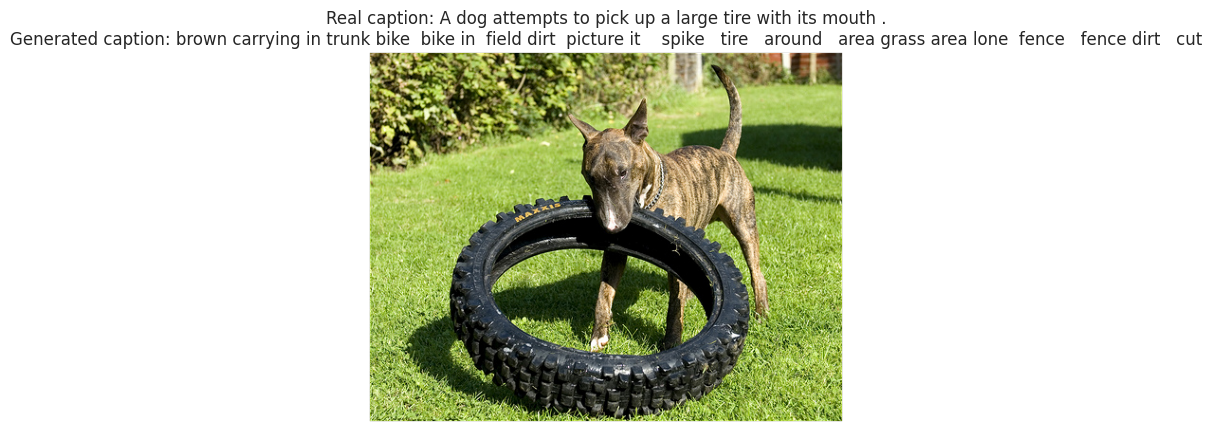

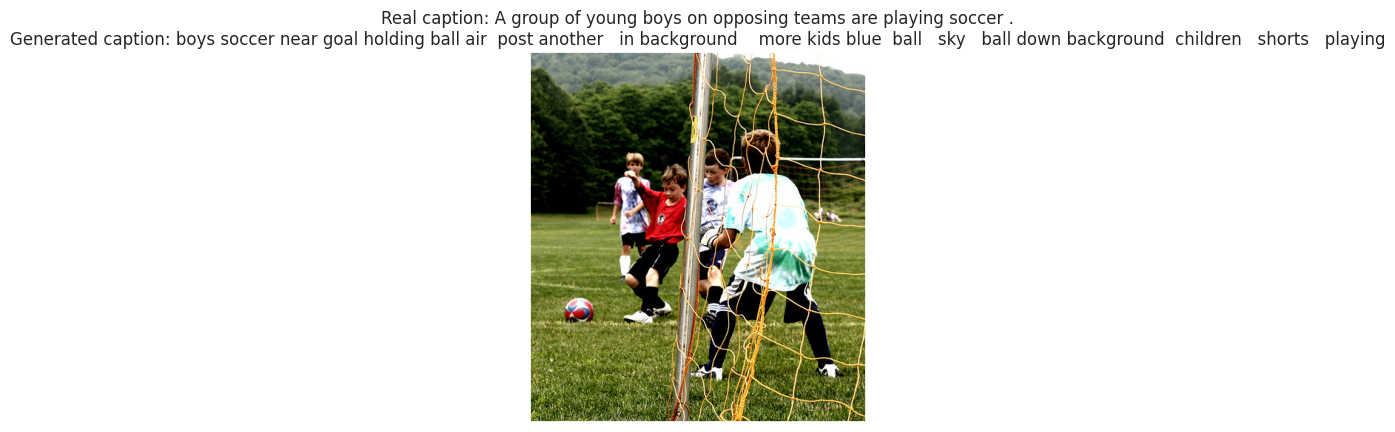

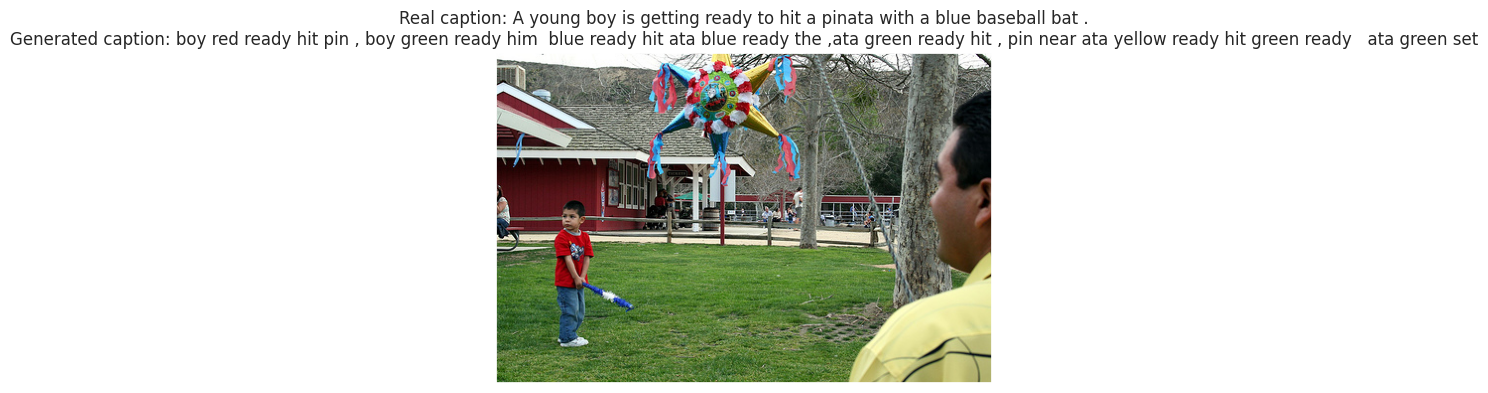

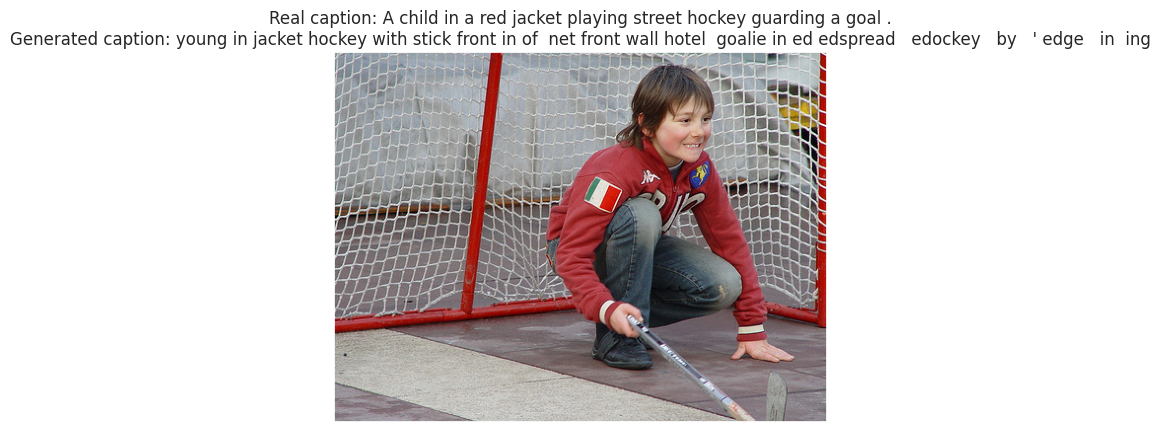

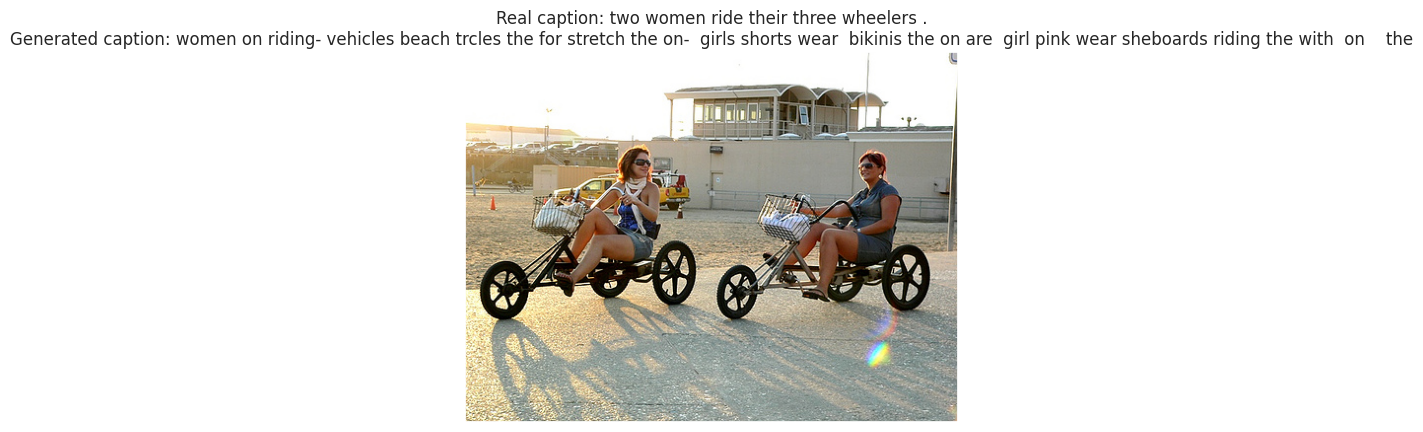

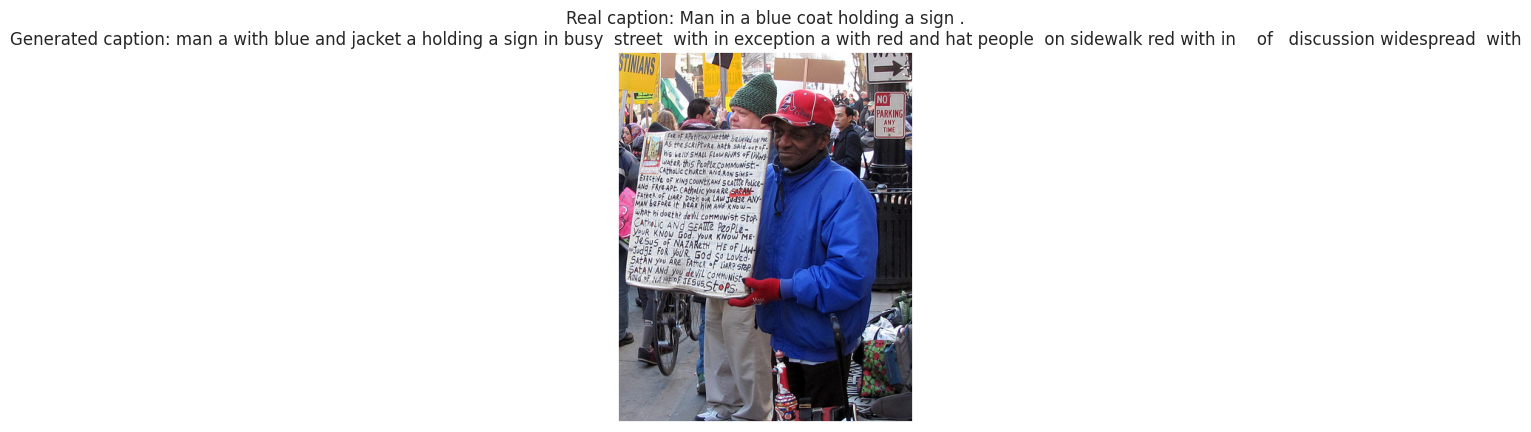

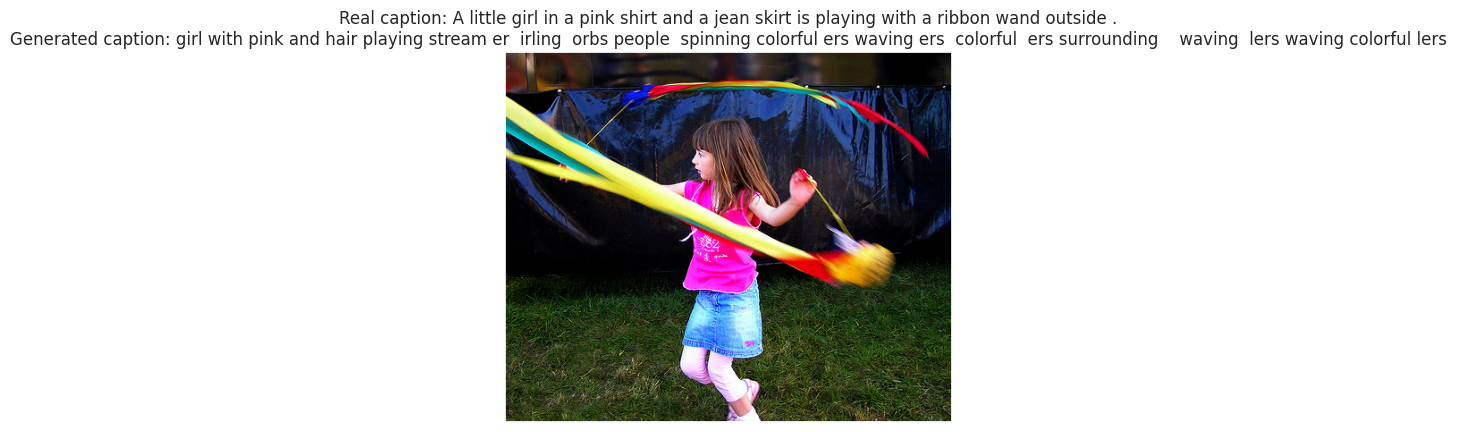

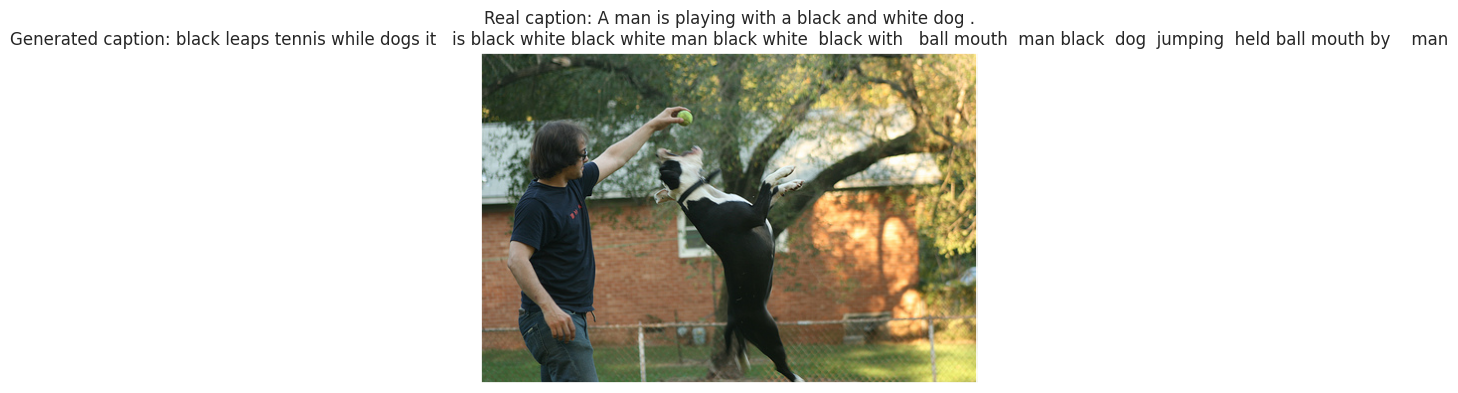

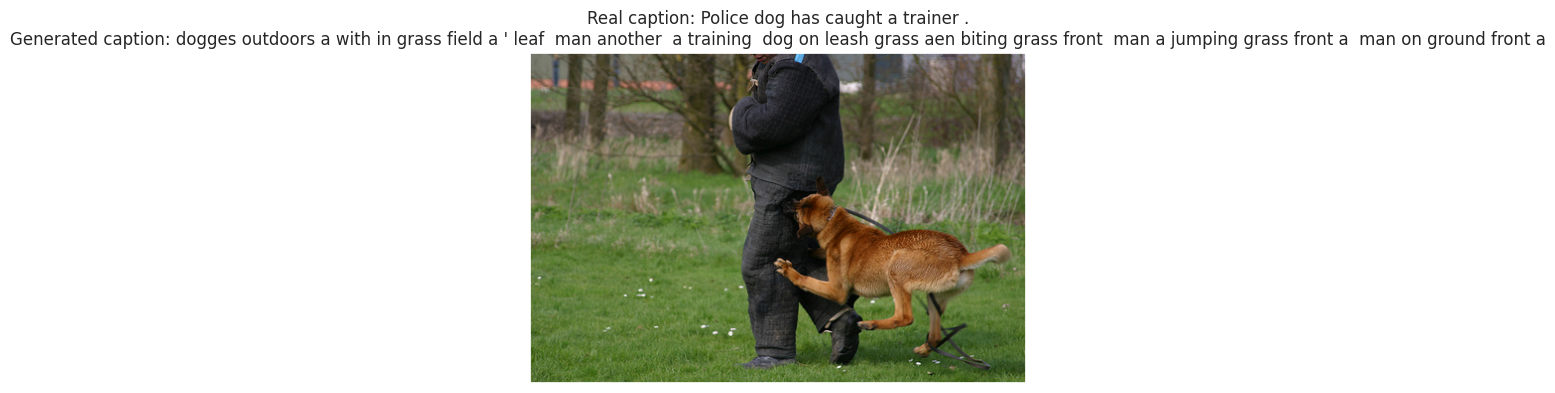

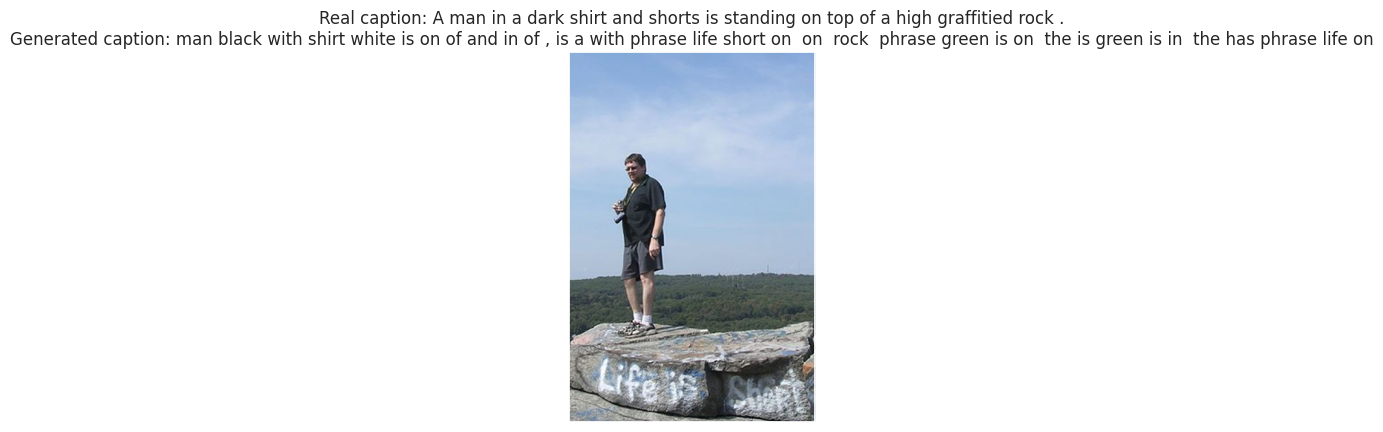

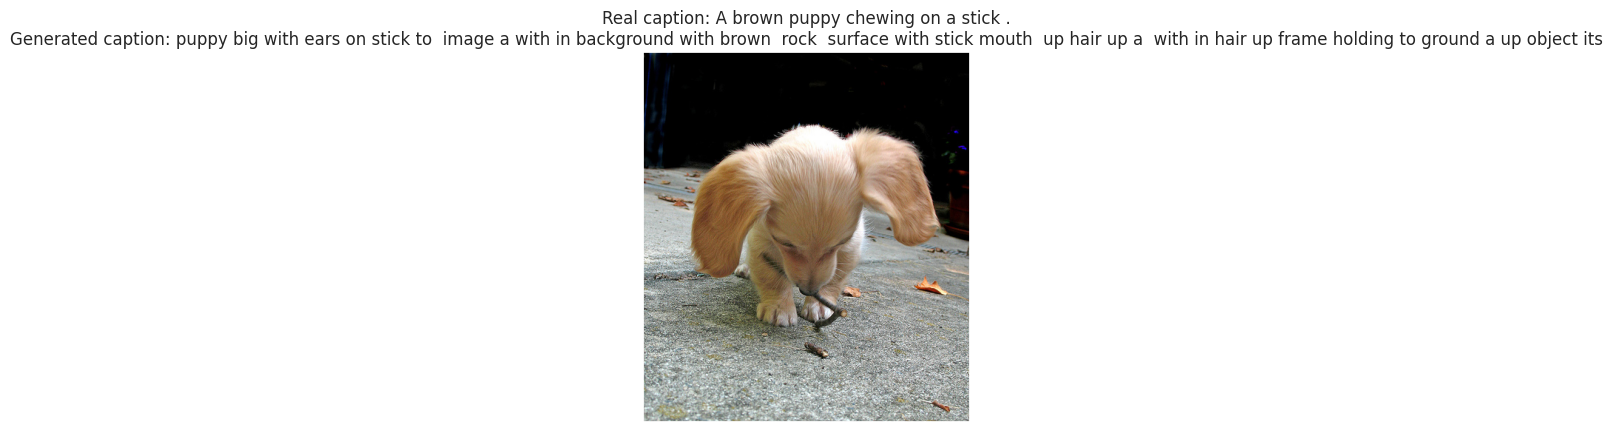

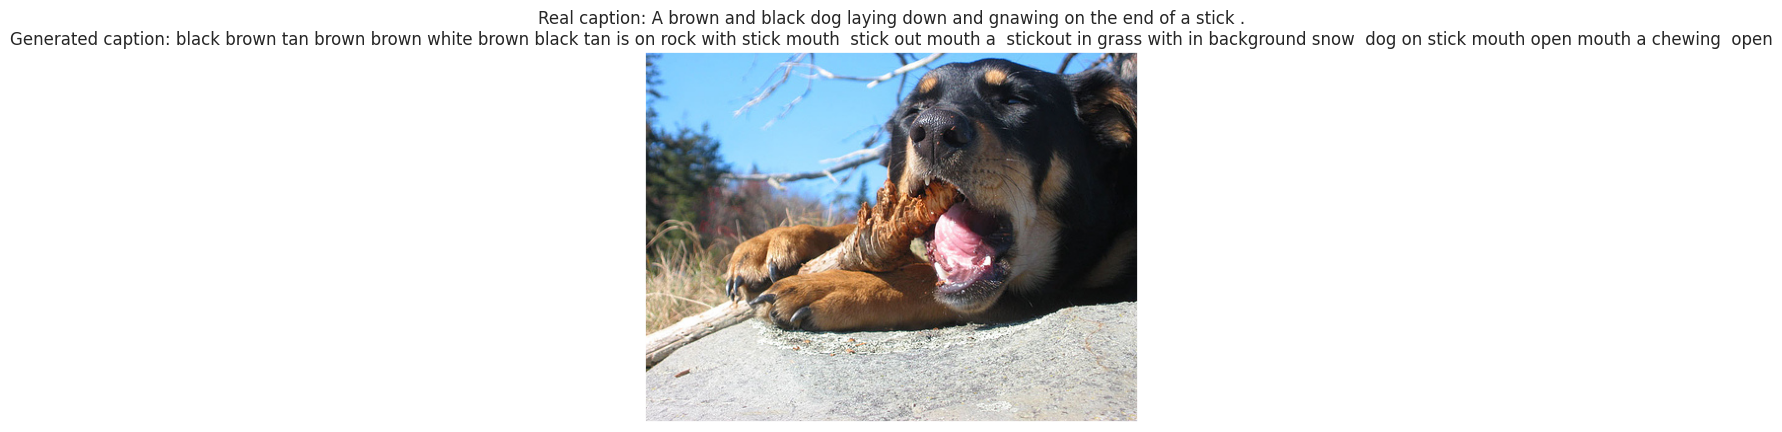

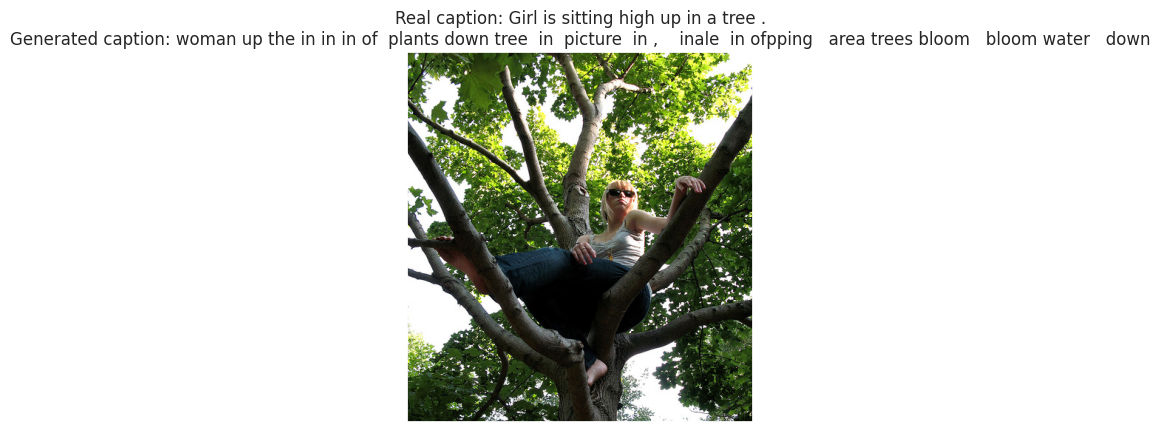

In [ ]:
for i in ids:
    pixel_values = valid_ds[i][0].unsqueeze(0).to(device)
    predictions = tokenizer.decode(model.generate(pixel_values=pixel_values)[0], skip_special_tokens=True)
    fact = valid_df.loc[int(i), 2]
    caption = predictions.replace('.', '').strip()

    im = plt.imread(valid_df.iloc[i].image)
    title = f'Real caption: {fact}\nGenerated caption: {caption}'

    plt.imshow(im)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

It looks like the model can capture the content of the images in most cases, but the generated captions contain many mistakes. This confusion likely stems from the model being trained on four different captions for each image. It would be interesting to see if training the model with only one caption per image.

**Conclusions:**

- Model can capture the content on the images
- Cpations are not natural because of different captions for a single image
- It would be a good idea to train a model with one caption for each image for the 1st experiment and one caption for each image in ~6000 images and remaining 2000 for the test and the validation sets.